#HR Separation. 
Checking the annual retirement and separation rates given a model.

In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
stgdir2local = '/home/kesj/work/hrsepara/proc'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')

/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Plan of attack:
1. read the data (after 2001)
2. obtain the set of current employees
3. Run through a model to get prediction(s) for retirement and separation
    * based upon the given model, preprocess it appropriately: for the server model use the minimal set of features and processing of the web_app code.
    * for the survival model ...
4. calc the total separation and retirements for each year and derive the rate of separation/retirement.
    * how do I determine the confidence intervals for these?

# Start here April 15, 2016

In [3]:
#os.chdir(stgdir1local)
os.chdir(stgdir2local)
em2002 = pd.read_csv('after2001_v3.csv',dtype={'EMPL_CLASS':np.str,'EEO1CODE':np.str})
                     #dtype={'EMPL_CLASS':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SHIFT':np.str,'VOLINVOL':np.str})
em2002.shape


(134266, 69)

## first define the current employees

In [4]:
current = em2002[em2002.status==0].copy() 

In [5]:
np.shape(current)

(69475, 69)

In [6]:
sum(current.EXT_FUNC_ID_SFI==909),sum(em2002.EXT_FUNC_ID_SFI==909)

(2587, 3193)

### Do survival analysis on specific employee types

In [7]:
from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()


In [8]:
em2002.former.value_counts()

0    84592
1    49674
Name: former, dtype: int64

In [9]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()
extFuncDict

{71: 'CCC Service',
 517: 'State Farm Bank',
 816: 'Life Health Response Center',
 835: 'SFPP',
 892: 'CCC Sales',
 909: 'Enterprise Auto Express',
 910: 'Enterprise ILR'}

In [10]:
len(em2002[em2002.EXT_FUNC_ID_SFI==909])

3193

In [11]:
em2002[em2002.EXT_FUNC_ID_SFI==909].former.value_counts()

0    2591
1     602
Name: former, dtype: int64

In [12]:
[c for c in em2002.columns if c.endswith('years')]

['Tenure_years', 'Age_years']

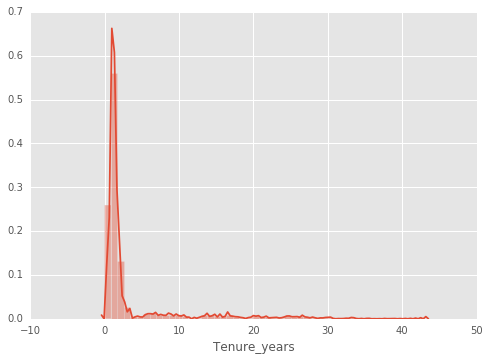

In [13]:
sns.distplot(em2002[em2002.EXT_FUNC_ID_SFI==909].Tenure_years)

In [14]:
em2002[em2002.EXT_FUNC_ID_SFI==909].former.value_counts()

0    2591
1     602
Name: former, dtype: int64

In [15]:
em2002[em2002.EXT_FUNC_ID_SFI==909].status.value_counts()

0    2587
1     606
Name: status, dtype: int64

In [16]:
em2002[em2002.EXT_FUNC_ID_SFI==892].retired.value_counts()

0    3347
1      17
Name: retired, dtype: int64

In [17]:
em2002[(em2002.EXT_FUNC_ID_SFI==909)&(em2002.retired==1)].Tenure_years

23524    33.199179
37350    43.110198
48440    30.414784
50144    21.598905
Name: Tenure_years, dtype: float64

In [18]:
em2002[(em2002.EXT_FUNC_ID_SFI==909)&(em2002.retired==0)    ].Tenure_years.describe()

count    3189.000000
mean        3.387741
std         6.097747
min         0.000000
25%         0.947296
50%         1.253936
75%         1.809719
max        41.481177
Name: Tenure_years, dtype: float64

In [21]:
T = em2002['Tenure_years'] #duration
C = em2002['former'] # observation

In [22]:
idx = em2002[(em2002.EXT_FUNC_ID_SFI==909)&(em2002.retired==0) &(em2002.Tenure_years<11)   ].index

inf


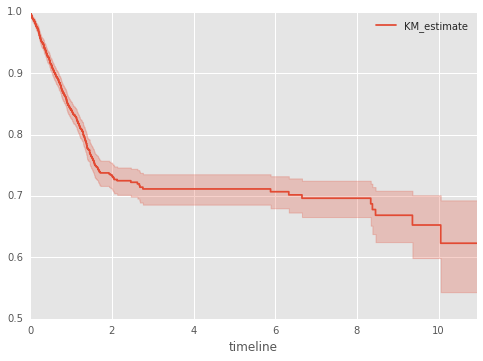

In [23]:
kmf.fit(T[idx],C[idx])#mygp.Tenure_years,event_observed=mygp.former,label=idno)
kmf.plot()
print(kmf.median_)

In [24]:
len(em2002[(em2002.EXT_FUNC_ID_SFI==909)&(em2002.retired==0) &(em2002.Tenure_years>1.2)   ])

1737

In [25]:
len(em2002[(em2002.EXT_FUNC_ID_SFI==892)&(em2002.retired==0) &(em2002.Tenure_years>10)   ])

129

In [26]:
em2002[(em2002.EXT_FUNC_ID_SFI==892)&(em2002.retired==0)    ].Tenure_years.describe()

count    3347.000000
mean        2.022958
std         3.633803
min         0.000000
25%         0.320329
50%         0.870637
75%         1.838467
max        35.375770
Name: Tenure_years, dtype: float64

In [27]:
len(em2002)

134266

In [29]:
[a for a in em2002[(em2002.EXT_FUNC_ID_SFI==909)&(em2002.Tenure_years>10)].columns if a.endswith("MOS")]

[]

In [30]:
em2002[(em2002.EXT_FUNC_ID_SFI==892)&(em2002.retired==0)].Tenure_years.quantile(.95)

8.1749486652949859

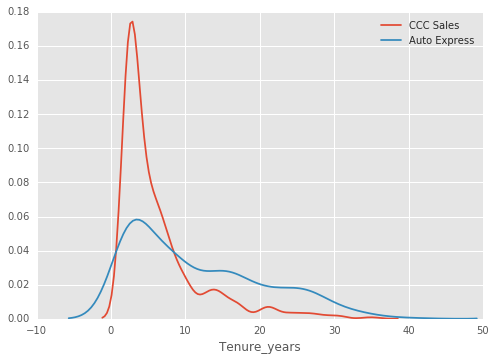

In [31]:
sns.distplot(em2002[(em2002.EXT_FUNC_ID_SFI==892)&(em2002.retired==0)&(em2002.Tenure_years>2)    ].Tenure_years,label='CCC Sales',hist=False)
sns.distplot(em2002[(em2002.EXT_FUNC_ID_SFI==909)&(em2002.retired==0) &(em2002.Tenure_years>2)   ].Tenure_years,label='Auto Express',hist=False)
plt.legend()

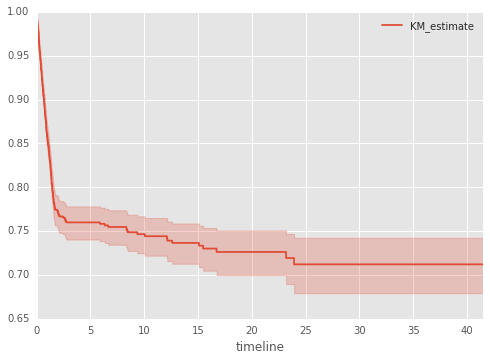

In [32]:
idno=909
ix = em2002[(em2002['EXT_FUNC_ID_SFI'] == idno) & (em2002.retired ==0)].index
#mygp = em2002[em2002.EXT_FUNC_ID_SFI==idno].copy()
kmf.fit(T[ix],C[ix])#mygp.Tenure_years,event_observed=mygp.former,label=idno)
kmf.plot()

In [33]:
kmf.median_

inf

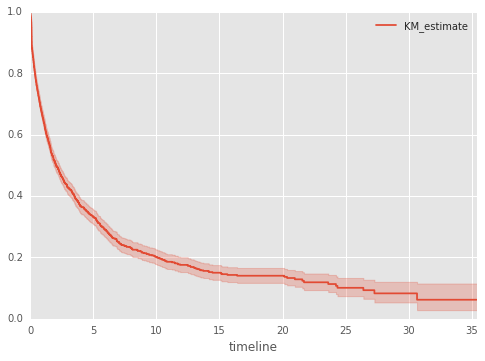

In [34]:
idno=892
kmf2 = KaplanMeierFitter()
ix = em2002[(em2002['EXT_FUNC_ID_SFI'] == idno) & (em2002.retired ==0)].index
#mygp = em2002[em2002.EXT_FUNC_ID_SFI==idno].copy()
kmf2.fit(T[ix],C[ix])#mygp.Tenure_years,event_observed=mygp.former,label=idno)
kmf2.plot()

In [35]:
kmf2.median_

2.0561259411400004

## May 9, 2016 Following up with an 'improved' model

In [36]:
previous_features_used = ['Age_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP','DEPTCNT1','EXTFUNC_CNT',
                          'FUNC_CNT','REMOTE','DIRECT_RPT_CNT','HUBIND','REH_CNT','JOB_FUNCTION_PSA']

### Preprocess the dataset to accommodate these features

In [38]:
all_cols = em2002.columns.tolist()
print(len(all_cols))

69


In [49]:
len(em2002)

134266

In [51]:
pd.crosstab(em2002.status,em2002.retired)

retired,0,1
status,,
0,69475,0
1,49674,15117


In [56]:
em2002.LOC_TYPE_DESCR_SFI.fillna('UNKNOWN',inplace=True)
em2002.isnull().any().sum()

0

In [57]:
loc_descriptions = em2002.LOC_TYPE_DESCR_SFI.unique().tolist()
short_loc_descript = {}
for loc_name in loc_descriptions:
    if loc_name.endswith(')'):
        short_name = loc_name[-4:-1]
        if short_name == 'NCE':
            short_loc_descript[loc_name]='TELE'
        else:
            short_loc_descript[loc_name]=short_name
    elif loc_name.startswith('TELE'):
        short_loc_descript[loc_name]='TELE'
    elif loc_name.endswith('SIU'):
        short_loc_descript[loc_name]='SIU'
    elif loc_name.startswith('OPERATIONS'):
        short_loc_descript[loc_name]='OC'
    elif loc_name.startswith('CORP'):
        short_loc_descript[loc_name]='CORP'
    elif loc_name.endswith('CENTER'):
        short_loc_descript[loc_name]='MC' # marketing center
    elif loc_name.endswith('AFO'):
        short_loc_descript[loc_name]='AFO'
    elif loc_name.endswith('OFFICE'):
        if loc_name.startswith('AGENT'):
            short_loc_descript[loc_name]='AO' # agent office
        elif loc_name.startswith('REGION'):
            short_loc_descript[loc_name]='RO' # regional office
        elif loc_name.startswith('CATA'):
            short_loc_descript[loc_name]='CAT' # catastrophe office
    elif loc_name.startswith('EST'):
        short_loc_descript[loc_name]='EST' # estimating station
    elif loc_name.startswith('ADM'):
        short_loc_descript[loc_name]='ADM' # estimating station
    elif loc_name.startswith('WARE'):
        short_loc_descript[loc_name]='WARE' # estimating station
    elif loc_name.startswith('VAC'):
        short_loc_descript[loc_name]='VAC' # estimating station
    elif loc_name.startswith('MULT-USE'):
        short_loc_descript[loc_name]='MF' # estimating station
    elif loc_name.startswith('MULT-REG'):
        short_loc_descript[loc_name]='MRSF' # estimating station
    else: 
        short_loc_descript[loc_name]='UNK'

print len(short_loc_descript.keys()), len(set(short_loc_descript.values()))

31 21


In [58]:
em2002['loc_desc']=em2002['LOC_TYPE_DESCR_SFI'].apply(lambda x: short_loc_descript[x])

## Identify categorical columns

In [61]:
bear_repo = '/home/kesj/lib/repo/bear/'
os.chdir(bear_repo)
import bear as br
os.chdir(stgdir2local)

In [62]:
### Define the categorical columns
cat_cols = br.get_categorical(em2002)
print len(cat_cols)
cat_cols.remove('LOC_TYPE_DESCR_SFI')

15


In [63]:
cat_cols

['EEO1CODE',
 'birth_tstmp',
 'FULL_PART_TIME',
 'EMPL_CLASS',
 'FLSA_STATUS',
 'LOC_STATE',
 'GRADE',
 'JOB_FAMILY',
 'hire_tstmp',
 'LOCATION',
 'term_tstmp',
 'JOB_FUNCTION',
 'EMPL_TYPE',
 'loc_desc']

In [64]:
sdf_cat = br.summarize_dataframe(em2002[cat_cols])
sdf_cat

,feature,datatype,nmissing,arity,accepted values,x_missing
0,EEO1CODE,object,0,10,"[2, 5, 1, 6, 3, 4, N, 7, 8, L]",0
1,birth_tstmp,object,0,20171,Too many to show,0
2,FULL_PART_TIME,object,0,4,"[N, F, X, P]",0
3,EMPL_CLASS,object,0,6,"[4, 1, D, 3, G, 5]",0
4,FLSA_STATUS,object,0,3,"[Z, N, X]",0
5,LOC_STATE,object,0,52,Too many to show,0
6,GRADE,object,0,125,Too many to show,0
7,JOB_FAMILY,object,0,1448,Too many to show,0
8,hire_tstmp,object,0,8881,Too many to show,0
9,LOCATION,object,0,13030,Too many to show,0


### look at the JOB_FUNCTION, JOB_GRADE in relation to these EXT_FUNC_IDSFI

In [65]:
em2002['JOB_FUNCTION'].value_counts()

PSA    52250
PTB    24746
PTA    15322
MGT    11111
NSA     5745
PTC     5268
PTE     5237
XX      4571
PSB     4172
PSC     3114
PTD      965
PTI      955
PTF      280
PTG      188
PTL      167
PTH      124
PTK       28
PTJ       21
PTM        2
Name: JOB_FUNCTION, dtype: int64

In [67]:
em2002[em2002['EXT_FUNC_ID_SFI']==909]['JOB_FUNCTION'].value_counts()

PSA    2634
MGT     255
PTA     229
PSC      72
NSA       3
Name: JOB_FUNCTION, dtype: int64

In [70]:
em2002[em2002['EXT_FUNC_ID_SFI']==909]['GRADE'].value_counts()

PA2    2471
MG2     222
RA1     201
PA3     147
PC2      51
RA3      28
MG4      23
PC3      19
UES       8
PA1       8
RA2       8
MG5       5
PC4       2
Name: GRADE, dtype: int64

In [74]:
em2002[em2002['JOBCODE']==983]['JOB_FUNCTION'].value_counts()

PSA    147
Name: JOB_FUNCTION, dtype: int64

In [75]:
147 + 2471

2618

### Restrict to non-retired

In [76]:
nr_em = em2002[em2002.retired==0].copy()
nr_em.shape

(119149, 70)

In [77]:
nr_em[nr_em['EXT_FUNC_ID_SFI']==909]['JOB_FUNCTION'].value_counts()

PSA    2633
MGT     254
PTA     228
PSC      71
NSA       3
Name: JOB_FUNCTION, dtype: int64

In [78]:
nr_em.JOB_FUNCTION.value_counts()

PSA    47430
PTB    22355
PTA    13781
MGT     9110
NSA     5062
PTE     4745
PTC     4536
XX      4015
PSB     3162
PSC     2500
PTD      939
PTI      924
PTL      165
PTG      162
PTF      131
PTH       88
PTK       26
PTJ       16
PTM        2
Name: JOB_FUNCTION, dtype: int64

In [79]:
cat_cols_to_dummy = sdf_cat[(sdf_cat.arity < 33) & (sdf_cat.arity>2)].sort_values(by='arity').feature.tolist()
cat_cols_to_dummy

['FLSA_STATUS',
 'FULL_PART_TIME',
 'EMPL_TYPE',
 'EMPL_CLASS',
 'EEO1CODE',
 'JOB_FUNCTION',
 'loc_desc']

In [80]:
binary_cat_cols = sdf_cat[sdf_cat.arity==2].feature.tolist()
binary_cat_cols

[]

In [84]:
## break this into a test/train 
from sklearn import cross_validation
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
ne2build, ne2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 60333)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(ne2eval),len(ne2build))

Starting with subset of 119149 employees.
Evaluation set has 23830 employees; training set has 95319 employees.


In [85]:
from sklearn.pipeline import Pipeline

In [88]:
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 #("label_encode",br.LabelEncodeColumn(cat_cols_to_label_encode)),
                 ("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],
                                                    criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 #("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 #("imp_mode",br.ImputeData(columns_to_impute=missing_cols,rows_to_scan=0.8))
                ])
                 

In [89]:
ne2build.columns

Index([u'EXT_FUNC_ID_SFI', u'EEO1CODE', u'REH_CNT', u'birth_tstmp', u'retired',
       u'FULL_PART_TIME', u'EMPL_CLASS', u'SHIFT', u'FLSA_STATUS',
       u'LOC_STATE', u'TOTAL_RPT_CNT', u'INTERN', u'GRADE', u'FUNCCNT1',
       u'PERF1', u'DEPENDENT_CNT', u'SUPVCNT1', u'Tenure_years', u'JOB_FAMILY',
       u'ANNUAL_RT', u'hire_tstmp', u'REMOTE', u'DIVISION_CODE_SFI',
       u'COMPANY', u'FLOORCNT1', u'FUNC_CNT', u'SEX', u'ETHNIC_GROUP',
       u'RELOCATE_ALL_SFI', u'LOCATION', u'HUBIND', u'PARTFULL1', u'STD_HOURS',
       u'JOBCNT1', u'term_tstmp', u'MIN_RT_ANNUAL', u'FLOR_SFI', u'PTFTCNT1',
       u'KEY', u'FULLPART1', u'FTPTCNT1', u'GRADECNT1', u'EFUNCCNT1',
       u'hire_age', u'HAVE_INS', u'FTE', u'JOB_FUNCTION', u'SAL1',
       u'LOCSTCNT1', u'former', u'EMPL_TYPE', u'EXTFUNC_CNT', u'JOBCODE',
       u'SUPV_DIFF_LOC', u'Age_years', u'ADDRCNT1', u'RELO_STATE_CNT_SFI',
       u'HAVE_DEP', u'REMOTE_SUPV', u'MAX_RT_ANNUAL', u'LOCCNT1', u'status',
       u'DIRECT_RPT_CNT', u'MERIT1', u'

In [91]:
modeling_cols = [c for c in ne2build.columns if not c.endswith('tstmp')]
print(len(modeling_cols))
modeling_cols

67


['EXT_FUNC_ID_SFI',
 'EEO1CODE',
 'REH_CNT',
 'retired',
 'FULL_PART_TIME',
 'EMPL_CLASS',
 'SHIFT',
 'FLSA_STATUS',
 'LOC_STATE',
 'TOTAL_RPT_CNT',
 'INTERN',
 'GRADE',
 'FUNCCNT1',
 'PERF1',
 'DEPENDENT_CNT',
 'SUPVCNT1',
 'Tenure_years',
 'JOB_FAMILY',
 'ANNUAL_RT',
 'REMOTE',
 'DIVISION_CODE_SFI',
 'COMPANY',
 'FLOORCNT1',
 'FUNC_CNT',
 'SEX',
 'ETHNIC_GROUP',
 'RELOCATE_ALL_SFI',
 'LOCATION',
 'HUBIND',
 'PARTFULL1',
 'STD_HOURS',
 'JOBCNT1',
 'MIN_RT_ANNUAL',
 'FLOR_SFI',
 'PTFTCNT1',
 'KEY',
 'FULLPART1',
 'FTPTCNT1',
 'GRADECNT1',
 'EFUNCCNT1',
 'hire_age',
 'HAVE_INS',
 'FTE',
 'JOB_FUNCTION',
 'SAL1',
 'LOCSTCNT1',
 'former',
 'EMPL_TYPE',
 'EXTFUNC_CNT',
 'JOBCODE',
 'SUPV_DIFF_LOC',
 'Age_years',
 'ADDRCNT1',
 'RELO_STATE_CNT_SFI',
 'HAVE_DEP',
 'REMOTE_SUPV',
 'MAX_RT_ANNUAL',
 'LOCCNT1',
 'status',
 'DIRECT_RPT_CNT',
 'MERIT1',
 'DEPTCNT1',
 'FUNC_ID_SFI',
 'LOC_TYPE_DESCR_SFI',
 'BOX1',
 'COMP_FREQUENCY',
 'loc_desc']

In [93]:
modeling_cols.remove('former')

In [94]:
ne2b = pipe.fit_transform(ne2build[modeling_cols],ne2build.status)
ne2e = pipe.fit(ne2build[modeling_cols],ne2build.status).transform(ne2eval[modeling_cols])

In [95]:
transformed_cols = ne2b.columns.tolist()
print(len(transformed_cols))

117


In [98]:
cols_to_omit = ['retired','SEX','HUBIND','ANNUAL_RT']
sep_model_cols = [c for c in transformed_cols if c not in cols_to_omit]
len(sep_model_cols)

113

In [100]:
sep_model_cols1 = [c for c in sep_model_cols if not c.startswith('loc_d')]
len(sep_model_cols1)

93

In [110]:
str_cols_to_drop = []
for col in sep_model_cols1:
    print(col, ne2b[col].dtype)
    if ne2b[col].dtype == 'O':
        str_cols_to_drop.append(col)

('EXT_FUNC_ID_SFI', dtype('int64'))
('REH_CNT', dtype('int64'))
('SHIFT', dtype('int64'))
('LOC_STATE', dtype('O'))
('TOTAL_RPT_CNT', dtype('float64'))
('INTERN', dtype('int64'))
('GRADE', dtype('O'))
('FUNCCNT1', dtype('int64'))
('PERF1', dtype('float64'))
('DEPENDENT_CNT', dtype('float64'))
('SUPVCNT1', dtype('int64'))
('Tenure_years', dtype('float64'))
('JOB_FAMILY', dtype('O'))
('REMOTE', dtype('int64'))
('DIVISION_CODE_SFI', dtype('int64'))
('COMPANY', dtype('int64'))
('FLOORCNT1', dtype('int64'))
('FUNC_CNT', dtype('float64'))
('ETHNIC_GROUP', dtype('float64'))
('RELOCATE_ALL_SFI', dtype('int64'))
('LOCATION', dtype('O'))
('PARTFULL1', dtype('int64'))
('STD_HOURS', dtype('float64'))
('JOBCNT1', dtype('int64'))
('MIN_RT_ANNUAL', dtype('float64'))
('FLOR_SFI', dtype('int64'))
('PTFTCNT1', dtype('int64'))
('KEY', dtype('int64'))
('FULLPART1', dtype('int64'))
('FTPTCNT1', dtype('int64'))
('GRADECNT1', dtype('int64'))
('EFUNCCNT1', dtype('int64'))
('hire_age', dtype('float64'))
('HAVE

In [111]:
sep_model_cols1 = [c for c in sep_model_cols1 if c not in str_cols_to_drop]
sep_model_cols1.remove('hire_age')
sep_model_cols1.remove('KEY')


In [112]:
ne2b[sep_model_cols1].shape

(95319, 86)

In [113]:
sep_model_cols1.remove('EXT_FUNC_ID_SFI')
sep_model_cols1.remove('FUNC_ID_SFI')
sep_model_cols1.remove('JOBCODE')
ne2b[sep_model_cols1].shape

(95319, 83)

In [99]:
import lifelines as ll

In [101]:
cf = ll.CoxPHFitter(penalizer=0.1)

In [121]:
sep_model_cols1

['REH_CNT',
 'SHIFT',
 'TOTAL_RPT_CNT',
 'INTERN',
 'FUNCCNT1',
 'PERF1',
 'DEPENDENT_CNT',
 'SUPVCNT1',
 'Tenure_years',
 'REMOTE',
 'DIVISION_CODE_SFI',
 'COMPANY',
 'FLOORCNT1',
 'FUNC_CNT',
 'RELOCATE_ALL_SFI',
 'PARTFULL1',
 'STD_HOURS',
 'JOBCNT1',
 'MIN_RT_ANNUAL',
 'FLOR_SFI',
 'PTFTCNT1',
 'FULLPART1',
 'FTPTCNT1',
 'GRADECNT1',
 'EFUNCCNT1',
 'HAVE_INS',
 'FTE',
 'SAL1',
 'LOCSTCNT1',
 'EXTFUNC_CNT',
 'SUPV_DIFF_LOC',
 'Age_years',
 'ADDRCNT1',
 'RELO_STATE_CNT_SFI',
 'HAVE_DEP',
 'REMOTE_SUPV',
 'MAX_RT_ANNUAL',
 'LOCCNT1',
 'status',
 'DIRECT_RPT_CNT',
 'MERIT1',
 'DEPTCNT1',
 'BOX1',
 'COMP_FREQUENCY',
 'FLSA_STATUS_N',
 'FLSA_STATUS_Z',
 'FULL_PART_TIME_F',
 'FULL_PART_TIME_P',
 'FULL_PART_TIME_X',
 'EMPL_TYPE_E',
 'EMPL_TYPE_S',
 'EMPL_TYPE_H',
 'EMPL_CLASS_1',
 'EMPL_CLASS_D',
 'EMPL_CLASS_3',
 'EMPL_CLASS_5',
 'EEO1CODE_2',
 'EEO1CODE_5',
 'EEO1CODE_4',
 'EEO1CODE_1',
 'EEO1CODE_6',
 'EEO1CODE_3',
 'EEO1CODE_7',
 'EEO1CODE_N',
 'JOB_FUNCTION_PTC',
 'JOB_FUNCTION_PTB',


In [117]:
ne2b[sep_model_cols1].ETHNIC_GROUP.value_counts()

1    65178
2    16558
3     8576
4     2442
8     1872
5      460
7      198
6       35
Name: ETHNIC_GROUP, dtype: int64

In [123]:
#sep_model_cols1.remove('ETHNIC_GROUP')
sep_model_cols1.remove('COMPANY')
sep_model_cols1.remove('DIVISION_CODE_SFI')

In [125]:
br.perfect_collinearity_test(ne2b[sep_model_cols1])

REH_CNT            VIF = 2.2   R^2 = 0.551     
SHIFT              VIF = 2.4   R^2 = 0.576     
TOTAL_RPT_CNT      VIF = 4.8   R^2 = 0.791     
INTERN             VIF = 3.8   R^2 = 0.7387    
FUNCCNT1           VIF = 3.1   R^2 = 0.6735    
PERF1              VIF = 4.2   R^2 = 0.7608    
DEPENDENT_CNT      VIF = 3.7   R^2 = 0.7325    
SUPVCNT1           VIF = 1.9   R^2 = 0.4754    
Tenure_years       VIF = 4.7   R^2 = 0.7892    
REMOTE             VIF = 2.6   R^2 = 0.6112    
FLOORCNT1          VIF = 2.4   R^2 = 0.5776    
FUNC_CNT           VIF = 4.7   R^2 = 0.7849    
RELOCATE_ALL_SFI   VIF = 27.1  R^2 = 0.9631    
PARTFULL1          VIF = 996.2 R^2 = 0.999     
STD_HOURS          VIF = 29113.9R^2 = 1.0       
JOBCNT1            VIF = 3.2   R^2 = 0.6922    
MIN_RT_ANNUAL      VIF = 161.6 R^2 = 0.9938    
FLOR_SFI           VIF = 2.8   R^2 = 0.6471    
PTFTCNT1           VIF = 996.8 R^2 = 0.999     
FULLPART1          VIF = 180.0 R^2 = 0.9944    
FTPTCNT1           VIF = 180.0 R^2 = 0.

REH_CNT             0.551017
SHIFT               0.575984
TOTAL_RPT_CNT       0.791026
INTERN              0.738680
FUNCCNT1            0.673496
PERF1               0.760829
DEPENDENT_CNT       0.732545
SUPVCNT1            0.475444
Tenure_years        0.789150
REMOTE              0.611236
FLOORCNT1           0.577587
FUNC_CNT            0.784946
RELOCATE_ALL_SFI    0.963075
PARTFULL1           0.998996
STD_HOURS           0.999966
JOBCNT1             0.692238
MIN_RT_ANNUAL       0.993812
FLOR_SFI            0.647063
PTFTCNT1            0.998997
FULLPART1           0.994443
FTPTCNT1            0.994444
GRADECNT1           0.644667
EFUNCCNT1           0.805480
HAVE_INS            0.776452
FTE                 0.999967
SAL1                0.945454
LOCSTCNT1           0.512770
EXTFUNC_CNT         0.662689
SUPV_DIFF_LOC       0.627468
Age_years           0.730513
                      ...   
EMPL_CLASS_1        0.999265
EMPL_CLASS_D        0.999142
EMPL_CLASS_3        0.995089
EMPL_CLASS_5  

In [130]:
sep_model_cols2 = [c for c in sep_model_cols1 if not c.startswith("EMPL_CLASS")]
sep_model_cols2 = [c for c in sep_model_cols2 if not c.startswith("EEO1CODE")]
len(sep_model_cols2)


68

In [132]:
%%time
#regression_dataset = load_regression_dataset()
#cf = CoxPHFitter()
scores = ll.utils.k_fold_cross_validation(cf, ne2b[sep_model_cols2], 'Tenure_years', event_col='status', k=3)
print (scores)
print (np.mean(scores))
print (np.std(scores))

#[ 0.5896  0.5358  0.5028]
# 0.542
# 0.035

[0.73563427075949928, 0.87199451176046416, 0.73544315228865764]
0.78102397827
0.0643259284389
CPU times: user 8min 30s, sys: 7min 41s, total: 16min 11s
Wall time: 4min 42s


In [133]:
cf.print_summary()

n=63546, number of events=26427

                         coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
REH_CNT             3.135e-02  1.032e+00 6.063e-02  5.170e-01 6.051e-01  -8.751e-02   1.502e-01     
SHIFT              -1.109e-02  9.890e-01 1.087e-01 -1.020e-01 9.188e-01  -2.242e-01   2.020e-01     
TOTAL_RPT_CNT       4.291e-03  1.004e+00 1.258e-01  3.410e-02 9.728e-01  -2.424e-01   2.510e-01     
INTERN             -7.734e-01  4.614e-01 3.528e-01 -2.192e+00 2.838e-02  -1.465e+00  -8.173e-02    *
FUNCCNT1           -2.241e-02  9.778e-01 1.184e-01 -1.892e-01 8.499e-01  -2.546e-01   2.097e-01     
PERF1               8.382e-01  2.312e+00 1.661e-02  5.046e+01 0.000e+00   8.056e-01   8.707e-01  ***
DEPENDENT_CNT       1.913e-01  1.211e+00 9.772e-02  1.958e+00 5.027e-02  -2.636e-04   3.829e-01    .
SUPVCNT1            7.232e-03  1.007e+00 1.052e-01  6.872e-02 9.452e-01  -1.991e-01   2.135e-01     
REMOTE             -2.624e-01  7.692e-01 1.884e-01 -1.393e

In [134]:
cf.hazards_

,REH_CNT,SHIFT,TOTAL_RPT_CNT,INTERN,FUNCCNT1,PERF1,DEPENDENT_CNT,SUPVCNT1,REMOTE,FLOORCNT1,...,JOB_FUNCTION_XX,JOB_FUNCTION_PTI,JOB_FUNCTION_PTD,JOB_FUNCTION_MGT,JOB_FUNCTION_PSB,JOB_FUNCTION_PTF,JOB_FUNCTION_PTH,JOB_FUNCTION_PTL,JOB_FUNCTION_PTJ,JOB_FUNCTION_PTK
coef,0.031351,-0.011087,0.004291,-0.773442,-0.02241,0.83816,0.191304,0.007232,-0.262393,-0.121686,...,-0.009925,0.071763,-0.241897,0.099008,0.012347,-0.026303,-0.022476,0.127049,0.00484,0.008527


In [135]:
def return_concordance(df,model,time_col,event_col):
    c_index = ll.utils.concordance_index(df[time_col].values,
                               model.predict_expectation(df).values.ravel(),
                               df[event_col].values.astype(int))
    return c_index

In [136]:
return_concordance(ne2e[sep_model_cols2],cf,'Tenure_years','status')

0.732520297842021

In [140]:
current = em2002[em2002.status== 0].copy()

In [141]:
curr = pipe.fit(ne2build[modeling_cols],ne2build.status).transform(current[modeling_cols])

In [142]:
%pwd

u'/home/kesj/work/hrsepara/proc'

In [143]:
import pickle 

In [144]:
pickle.dump( cf, open( "separation_coxph_may16a.pkl", "wb" ) )

## Apply this model to the current employees and assess accuracy

In [145]:
from scipy import interpolate
from scipy.optimize import curve_fit

def forecast_survival_function(mdl, df, time_range=[0, 1, 2, 3, 4, 5], calc_ci=True, extrapolate=False):
    """
        :param self:
        :param df:

        :param time_range:
        :param calc_ci: flag to return the confidence intervals
        :return:
    """

    # time_col = self.durations.name

    col_names = ['t_' + np.str(tp) for tp in time_range]
    # calculate the predicted hazard
    #order = mdl.confidence_intervals_.columns.tolist()
    #duration_col = mdl.durations.name
    #order.append(duration_col)
    #df = df[order]
    my_partial_hazard = mdl.predict_partial_hazard(df)
    print(df.shape)
    # assign the specific timepoints and calculate the cumulative hazards at these points
    forecast_times = identify_forecast_timepoints(mdl, df, time_range)
    max_time = mdl.baseline_hazard_.index.max()
    print(max_time)
    if extrapolate:
        # do a linear extrapolation of the cumulative hazards and use this to get values beyond the known range
        p_haz, p_haz_cov = curve_fit(line, mdl.baseline_cumulative_hazard_.index,
                                     mdl.baseline_cumulative_hazard_.values.ravel())
        # force the points to match
        offset = mdl.baseline_cumulative_hazard_.values[-1][0] - line(mdl.baseline_cumulative_hazard_.index[-1],
                                                                      p_haz[0], p_haz[1])
        # apply to timepoints
        specific_cumulative_hazards = forecast_times.applymap(lambda x: return_desired_cumulative_hazards(mdl, x)
        if x <= max_time else offset + line(x, p_haz[0], p_haz[1]))
    else:  # this is the default case
        # replace those that exceed the max-time observed with the max observed time
        forecast_times[forecast_times > max_time] = max_time
        specific_cumulative_hazards = forecast_times.applymap(lambda x: return_desired_cumulative_hazards(x, mdl))

        # predict the survival function at these forecasted times
        pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                             my_partial_hazard.values)), index=df.index)

    if calc_ci:
        # calculate the predicted hazard
        try:
            partial_hazard_ci = mdl.predict_partial_hazard_ci(df)
        except AttributeError:
            #df_index = mdl._get_index(df)
            if isinstance(df, pd.DataFrame):
                order = mdl.hazards_.columns
                df = df[order]
            if mdl.normalize:
                df2 = ll.utils.normalize(df, mdl._norm_mean.values, mdl._norm_std.values)
            partial_hazard_ci = pd.DataFrame(np.exp(np.dot(df2, mdl.confidence_intervals_.T)), index=df.index.tolist())
            partial_hazard_ci['lowerbound'] = partial_hazard_ci.min(axis=1)
            partial_hazard_ci['upperbound'] = partial_hazard_ci.max(axis=1)
            partial_hazard_ci = partial_hazard_ci[['lowerbound', 'upperbound']]

        pred_lower_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:, 1])),
                                              columns=df.index).T
        pred_upper_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:, 0])),
                                              columns=df.index).T

        surv_prediction = pd.Panel(data={'surv': pred_survival_fcn, 'lbci': pred_lower_survival_ci,
                                         'ubci': pred_upper_survival_ci})
    else:
        surv_prediction = pd.Panel(data={'surv': pred_survival_fcn})

    surv_prediction.minor_axis = col_names

    return surv_prediction

## Forecast forward in 1 year intervals
def identify_forecast_timepoints(mdl, X, time_range):
    """
        :param X: a (n,d) covariate numpy array or DataFrame. If a numpy array, it is coerced into a DataFrame
        :param time_range: a list of times to calculate the survival for.
        :return: time_point_df a DataFrame of selected future times to create survival forecasts for.

        Construct a data frame that has the current time_col for each observation incremented by the values in the
        desired list (time_range)
    """
    time_col = mdl.durations.name
    column_names = ['time_point_' + np.str(tp) for tp in time_range]
    if isinstance(X, pd.DataFrame):
        my_index = X.index.tolist()
    else:
        my_index = np.arange(0, len(X))
        X = pd.DataFrame(X, columns=mdl.hazards_.columns)

    time_point_df = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([X.loc[idx, time_col] + tp for tp in time_range])
        time_point_df.ix[idx] = my_times

    return time_point_df


def line(x, a, b):
    return a * x + b


def return_desired_cumulative_hazards(t, mdl):
    """
    t: an event time that is used as the base line to forecast forward in time
    """
    maxtimepoint = mdl.baseline_hazard_.index.max()  # Now taken care of in the forecast
    if t > maxtimepoint:
        t = maxtimepoint  # just set to the max value.
    try:
        # spec_hazard = self.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]

    except KeyError:
        # get the first after this point
        t_post = mdl.baseline_hazard_.ix[t:].index[0]
        # get the last before this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1]
        # x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],
             mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        # print(x, y)
        chaz_interp = interpolate.interp1d([t_prior, t_post], y)
        c_haz = chaz_interp(t)

    return c_haz


def convert_surv_to_prob(surv_pred, pred_type, keyed_df):
    prob = {}

    for item in surv_pred.items:
        if item == 'lbci':
            prob['ubcip'] = pd.concat([keyed_df, 1 - surv_pred[item]], axis=1)
            prob['ubcip'].fillna(0, inplace=True)
        elif item == 'ubci':
            prob['lbcip'] = pd.concat([keyed_df, 1 - surv_pred[item]], axis=1)
            prob['lbcip'].fillna(0, inplace=True)
        else:
            prob['surv'] = pd.concat([keyed_df, 1 - surv_pred[item]], axis=1)
            prob['surv'].fillna(0, inplace=True)



    # now check that lengths match
    # if len(surv_pred['surv'])!=len(keyed_df):
    #    for item in surv_pred.items:
    #        prob[item]
    #timepoint_cols = surv_pred.minor_axis.tolist()
    if pred_type == 'ret':
        rep_string = 'ret_prob'
    elif pred_type == 'sep':
        rep_string = 'sep_prob'

    probabilities = pd.Panel.from_dict(prob)
    probabilities.minor_axis = [a.replace('t', rep_string) for a in probabilities.minor_axis.tolist()]

    return probabilities

In [149]:
take20 = curr.head(20).copy()

In [155]:
my_partial_hazard = cf.predict_partial_hazard(curr[sep_model_cols2])

In [156]:
forecast_times = identify_forecast_timepoints(cf, curr[sep_model_cols2], [0,1,2,3,4,5])

In [157]:
max_time = cf.baseline_hazard_.index.max()
print(max_time)

51.0718685832


In [158]:
#curr_surv_pred = forecast_survival_function(cf,take20,'Tenure_years')
forecast_times[forecast_times > max_time] = max_time
specific_cumulative_hazards = forecast_times.applymap(lambda x: return_desired_cumulative_hazards(x, cf))

        # predict the survival function at these forecasted times
pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                             my_partial_hazard.values)), index=curr[sep_model_cols2].index)

In [159]:
col_names = ['t_' + np.str(tp) for tp in [0,1,2,3,4,5]]

In [160]:
df = curr[sep_model_cols2].copy()
mdl = cf
try:
    partial_hazard_ci = cf.predict_partial_hazard_ci(df)
except AttributeError:
            #df_index = mdl._get_index(df)
    if isinstance(df, pd.DataFrame):
        order = mdl.hazards_.columns
        df = df[order]
    if mdl.normalize:
        df2 = ll.utils.normalize(df, mdl._norm_mean.values, mdl._norm_std.values)
    partial_hazard_ci = pd.DataFrame(np.exp(np.dot(df2, mdl.confidence_intervals_.T)), index=df.index.tolist())
    partial_hazard_ci['lowerbound'] = partial_hazard_ci.min(axis=1)
    partial_hazard_ci['upperbound'] = partial_hazard_ci.max(axis=1)
    partial_hazard_ci = partial_hazard_ci[['lowerbound', 'upperbound']]
    



In [161]:
pred_lower_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                          partial_hazard_ci.values[:, 1])), 
                                      columns=df.index).T
pred_upper_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                          partial_hazard_ci.values[:, 0])),
                                      columns=df.index).T

surv_prediction = pd.Panel(data={'surv': pred_survival_fcn, 'lbci': pred_lower_survival_ci,
                                         'ubci': pred_upper_survival_ci})
surv_prediction.minor_axis = col_names


In [172]:
len(surv_prediction['surv'])

69475

### look at just the 909 people now

In [173]:
#identify_forecast_timepoints(cf,take20[sep_model_cols2],[0,1,2,3,4,5])
#cf.durations.name
idx = curr[curr.EXT_FUNC_ID_SFI==909].index
len(idx)

2587

In [174]:
idx

Int64Index([93611, 93612, 93613, 93614, 93615, 93616, 93617, 93618, 93619,
            93620,
            ...
            96188, 96189, 96190, 96191, 96192, 96193, 96194, 96195, 96196,
            96197],
           dtype='int64', length=2587)

In [182]:
sep_surv_prob = 1-surv_prediction['surv']
sep_surv_prob.max()

t_0    1
t_1    1
t_2    1
t_3    1
t_4    1
t_5    1
dtype: float64

In [188]:
(sep_surv_prob.loc[idx]['t_5']>=0.5).astype(int).sum(axis=0)

1

In [195]:
(sep_surv_prob['t_1']>=0.5).astype(int).sum(axis=0)

58

## now look to apply the HRserver model (reduced column)

In [198]:
sep_cox_march = ll.CoxPHFitter()
march_columns = [a for a in previous_features_used]
march_columns.append('Tenure_years')
march_columns.append('status')

sep_cox_march.fit(ne2b[march_columns],'Tenure_years','status')


<lifelines.CoxPHFitter: fitted with 95319 observations, 55678 censored>

In [201]:
sep_cox_march.print_summary()

n=95319, number of events=39641

                       coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years        -9.231e-01  3.973e-01 9.197e-03 -1.004e+02  0.000e+00  -9.411e-01  -9.051e-01  ***
SAL1             -8.096e-01  4.450e-01 1.223e-02 -6.621e+01  0.000e+00  -8.336e-01  -7.856e-01  ***
MERIT1            1.179e-01  1.125e+00 8.797e-03  1.341e+01  5.460e-41   1.007e-01   1.352e-01  ***
PERF1            -1.029e+00  3.572e-01 1.725e-02 -5.966e+01  0.000e+00  -1.063e+00  -9.956e-01  ***
BOX1             -1.601e-01  8.521e-01 7.608e-03 -2.104e+01  2.677e-98  -1.750e-01  -1.452e-01  ***
SEX               1.500e-01  1.162e+00 5.471e-03  2.742e+01 1.634e-165   1.393e-01   1.607e-01  ***
HAVE_INS         -2.556e-01  7.745e-01 8.194e-03 -3.119e+01 1.457e-213  -2.716e-01  -2.395e-01  ***
HAVE_DEP         -2.097e-01  8.108e-01 1.041e-02 -2.014e+01  3.065e-90  -2.301e-01  -1.893e-01  ***
DEPTCNT1         -2.809e-01  7.551e-01 8.538e-03 -3.290e+01 2.255e-

In [202]:
hr_march_sep_surv = forecast_survival_function(sep_cox_march, curr[march_columns], time_range=[0, 1, 2, 3, 4, 5])

(69475, 18)
61.5797399042


In [209]:
(1-hr_march_sep_surv['surv'].loc[idx,'t_1']>=0.5).astype(int).sum()

63

#### Try to eliminate 'SEX' and 'HUBIND'

In [203]:
sep_cf_mar_less = ll.CoxPHFitter()
#march_columns = [a for a in previous_features_used]
#march_columns.append('Tenure_years')
#march_columns.append('status')
mar_less_cols = [a for a in march_columnsumns]
mar_less_cols.remove('HUBIND')
mar_less_cols.remove('SEX')

sep_cf_mar_less.fit(ne2b[mar_less_cols],'Tenure_years','status')
sep_cf_mar_less.print_summary()


n=95319, number of events=39641

                       coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years        -9.384e-01  3.913e-01 9.132e-03 -1.028e+02  0.000e+00  -9.563e-01  -9.205e-01  ***
SAL1             -7.551e-01  4.700e-01 1.188e-02 -6.355e+01  0.000e+00  -7.784e-01  -7.318e-01  ***
MERIT1            1.095e-01  1.116e+00 8.874e-03  1.233e+01  5.946e-35   9.206e-02   1.269e-01  ***
PERF1            -1.033e+00  3.560e-01 1.716e-02 -6.021e+01  0.000e+00  -1.067e+00  -9.993e-01  ***
BOX1             -1.657e-01  8.473e-01 7.580e-03 -2.187e+01 5.536e-106  -1.806e-01  -1.509e-01  ***
HAVE_INS         -2.570e-01  7.734e-01 8.112e-03 -3.169e+01 2.474e-220  -2.729e-01  -2.411e-01  ***
HAVE_DEP         -2.117e-01  8.092e-01 1.040e-02 -2.035e+01  4.342e-92  -2.321e-01  -1.913e-01  ***
DEPTCNT1         -2.898e-01  7.484e-01 8.519e-03 -3.401e+01 1.466e-253  -3.065e-01  -2.731e-01  ***
EXTFUNC_CNT       7.651e-02  1.080e+00 4.923e-03  1.554e+01  1.823e

In [331]:
sep_cf_mar_less.hazards_.T

,coef
Age_years,-0.938373
SAL1,-0.755070
MERIT1,0.109458
PERF1,-1.032931
BOX1,-0.165742
HAVE_INS,-0.257020
HAVE_DEP,-0.211719
DEPTCNT1,-0.289761
EXTFUNC_CNT,0.076511
FUNC_CNT,-0.119384


In [267]:
pickle.dump( sep_cf_mar_less, open( "separation_coxph_min_vars.pkl", "wb" ) )

In [210]:
hr_mar_less_sep_surv = forecast_survival_function(sep_cf_mar_less, curr[mar_less_cols], time_range=[0, 1, 2, 3, 4, 5])

(69475, 16)
61.5797399042


In [270]:
(1-hr_mar_less_sep_surv['surv'].loc[idx,'t_1']>=0.5).astype(int).sum()

79

## calculate the number that are predicted to retire in time frame

In [273]:
def convert_surv_to_prob(surv_pred, pred_type, keyed_df):
    prob = {}

    for item in surv_pred.items:
        if item == 'lbci':
            prob['ubcip'] = pd.concat([keyed_df, 1 - surv_pred[item]], axis=1)
            prob['ubcip'].fillna(0, inplace=True)
        elif item == 'ubci':
            prob['lbcip'] = pd.concat([keyed_df, 1 - surv_pred[item]], axis=1)
            prob['lbcip'].fillna(0, inplace=True)
        else:
            prob['surv'] = pd.concat([keyed_df, 1 - surv_pred[item]], axis=1)
            prob['surv'].fillna(0, inplace=True)

    # now check that lengths match
    # if len(surv_pred['surv'])!=len(keyed_df):
    #    for item in surv_pred.items:
    #        prob[item]
    #timepoint_cols = surv_pred.minor_axis.tolist()
    if pred_type == 'ret':
        rep_string = 'ret_prob'
    elif pred_type == 'sep':
        rep_string = 'sep_prob'

    probabilities = pd.Panel.from_dict(prob)
    probabilities.minor_axis = [a.replace('t', rep_string) for a in probabilities.minor_axis.tolist()]

    return probabilities

def reduce_to_sums(prob, thresh=0.5):
    my_counts = {}
    prob_cols = prob['surv'].columns.tolist()[1:]
    for item in prob.items:
        my_counts[item] = (prob[item][prob_cols] >= thresh).astype(int).sum(axis=0)

    df_counts = pd.DataFrame.from_dict(my_counts)
    return df_counts

In [272]:
hr_mar_less_prob = convert_surv_to_prob(hr_mar_less_sep_surv, 'sep', pd.DataFrame(curr.KEY))

In [274]:
mar_less_sep_counts = reduce_to_sums(hr_mar_less_prob)

## Compare to the existing model in comparison to the known out of time samples for 2015 
(based upon the original March 2016 model I gave them; thus it included 'SEX' and 'HUBIND'
#### Looking at specific groups where there is typically high turnover

In [212]:
summary2015_group_data = pd.DataFrame(columns = ['GROUP','grp_id','GROUP_TYPE','GroupCount','sep2015','HR1yrsep','SR1yrsep','1yrLB','1yrUB'],
                            data = [['CCC_Service',71,'EXT FUNC',1823,466,210,710,646,770],
['BANK',517,'EXT FUNC',1507,100,94,135,114,157],
['L/H RC',816,'EXT FUNC',376,88,32,71,56,85],
['CCC SALES',892,'EXT FUNC',1636,391,198,524,463,573],
['EXPRESS',909,'EXT FUNC',2587,506,252,63,51,73],
['ILR',910,'EXT FUNC',2462,855,326,472,420,520],
['BANK SERVICE REP',[851,852,853],'JOBCODE',188,27,18,32,7,6],
['CLM ASSOC EXPRESS',[983,984],'JOBCODE',2039,483,229,6,5,6],
['CLM TEAM MGR ILR',[986],'JOBCODE',209,4,7,5,5,5],
['CLM ASSOC ILR',[1009],'JOBCODE',2012,834,306,460,409,506],
['CCC SALES REP',[1876],'JOBCODE',1474,379,190,513,53,561],
['LIFE SERVICE REP',[2638,2639,2641],'JOBCODE',636,106,42,125,107,147],
['SFPP A/C REP',[4105],'JOBCODE',234,51,36,110,96,124],
['CCC SERVICE REP',[6200],'JOBCODE',1472,433,189,648,590,703],
['ALL',0,'ALL', 69476, 5234, 3048, 4579,4093,5042]]
)

In [213]:
summary2015_group_data

,GROUP,grp_id,GROUP_TYPE,GroupCount,sep2015,HR1yrsep,SR1yrsep,1yrLB,1yrUB
0,CCC_Service,71,EXT FUNC,1823,466,210,710,646,770
1,BANK,517,EXT FUNC,1507,100,94,135,114,157
2,L/H RC,816,EXT FUNC,376,88,32,71,56,85
3,CCC SALES,892,EXT FUNC,1636,391,198,524,463,573
4,EXPRESS,909,EXT FUNC,2587,506,252,63,51,73
5,ILR,910,EXT FUNC,2462,855,326,472,420,520
6,BANK SERVICE REP,"[851, 852, 853]",JOBCODE,188,27,18,32,7,6
7,CLM ASSOC EXPRESS,"[983, 984]",JOBCODE,2039,483,229,6,5,6
8,CLM TEAM MGR ILR,[986],JOBCODE,209,4,7,5,5,5
9,CLM ASSOC ILR,[1009],JOBCODE,2012,834,306,460,409,506


In [332]:
summary2015_group_data.to_csv('sep_surv_1yr_holdout_comparison.csv',index=False)

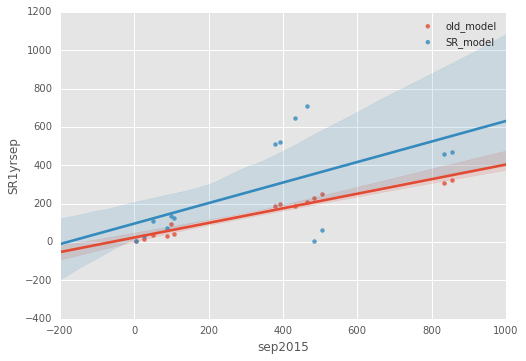

In [215]:
x = np.arange(0,950,1)
#plt.plot(x,x,c='k')
sns.regplot(x='sep2015',y='HR1yrsep',data=summary2015_group_data.iloc[:-1],label='old_model')

sns.regplot(x='sep2015',y='SR1yrsep',data=summary2015_group_data.iloc[:-1],label='SR_model')
plt.legend()

### Define these interesting job cases

In [276]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()

jobCodeDict = {}
jobCodeDict[6200]= 'CCC Service Rep'
jobCodeDict[1876]= 'CCC Sales Rep'
jobCodeDict[1009]='CLaim Associate-ILR'
jobCodeDict[986]='CLaim Team Manager-ILR'
jobCodeDict[983]='Claim Associate-Express'
jobCodeDict[984]='Claim Associate-Express'
jobCodeDict[2638]='Life Customer Service Asst'
jobCodeDict[2639]='Life Customer Service Asst'
jobCodeDict[2641]='Life Customer Service Asst'
jobCodeDict[4105]= 'SFPP Account Rep'
jobCodeDict[851]= 'Bank Customer Service Rep'
jobCodeDict[852]= 'Bank Customer Service Rep'
jobCodeDict[853]= 'Bank Customer Service Rep'
interesting_jobcodes =  jobCodeDict.keys()



In [277]:
mar_less_sep_counts

,lbcip,surv,ubcip
sep_prob_0,1843,2091,2374
sep_prob_1,3952,4450,4990
sep_prob_2,6173,6738,7306
sep_prob_3,8291,8844,9367
sep_prob_4,10278,10782,11316
sep_prob_5,12217,12693,13235


## get the 1 year predictions for each subgroup

In [ ]:
mar_less_sep_counts = reduce_to_sums(hr_mar_less_prob)

In [314]:
def get_subgroup_pred(prob, df, gpfeature, gpvalue, gptype='straight', time_point=1, verbose=False,
                      panel_frames = ['surv','lbcip','ubcip'], my_thresh=0.5):
    if gptype=='straight':
        subset = df[df[gpfeature]==gpvalue].index
    elif gptype == 'isin':
        subset = df[df[gpfeature].isin(gpvalue)].index
    nmembers = len(subset)
    print("Group {0} has {1} members".format(gpvalue,nmembers))
    subgroup_counts = []
        
    for panel in panel_frames:
        counts = (prob[panel].loc[subset]>=my_thresh).astype(int).sum()
        subgroup_counts.append(counts[time_point+1])
        if verbose:
            print ("____________ {0}\n".format(panel))
            print(counts)
        
        
    return subgroup_counts
        

In [309]:
(hr_mar_less_prob['surv'].loc[idx]>=0.5).astype(int).sum()

KEY           2587
sep_prob_0      19
sep_prob_1      79
sep_prob_2     239
sep_prob_3     466
sep_prob_4     681
sep_prob_5     876
dtype: int64

In [312]:
get_subgroup_pred(hr_mar_less_prob,curr,'EXT_FUNC_ID_SFI',909)

Group 909 has 2587 members
____________ surv

KEY           2587
sep_prob_0      19
sep_prob_1      79
sep_prob_2     239
sep_prob_3     466
sep_prob_4     681
sep_prob_5     876
dtype: int64
____________ lbcip

KEY           2587
sep_prob_0      18
sep_prob_1      58
sep_prob_2     198
sep_prob_3     423
sep_prob_4     636
sep_prob_5     843
dtype: int64
____________ ubcip

KEY           2587
sep_prob_0      21
sep_prob_1     110
sep_prob_2     297
sep_prob_3     514
sep_prob_4     734
sep_prob_5     920
dtype: int64


[79, 58, 110]

## now loop over the different subgroups I care about

In [317]:
exfc_counts = {}
for key in extFuncDict.keys():
    exfc_counts[extFuncDict[key]]    = get_subgroup_pred(hr_mar_less_prob,curr,'EXT_FUNC_ID_SFI',key)

Group 835 has 783 members
Group 517 has 1507 members
Group 71 has 1823 members
Group 909 has 2587 members
Group 910 has 2462 members
Group 816 has 376 members
Group 892 has 1636 members


In [318]:
exfc_counts

{'CCC Sales': [549, 470, 615],
 'CCC Service': [753, 668, 831],
 'Enterprise Auto Express': [79, 58, 110],
 'Enterprise ILR': [534, 458, 610],
 'Life Health Response Center': [69, 55, 80],
 'SFPP': [166, 145, 190],
 'State Farm Bank': [140, 118, 159]}

{851: 'Bank Customer Service Rep',
 852: 'Bank Customer Service Rep',
 853: 'Bank Customer Service Rep',
 983: 'Claim Associate-Express',
 984: 'Claim Associate-Express',
 986: 'CLaim Team Manager-ILR',
 1009: 'CLaim Associate-ILR',
 1876: 'CCC Sales Rep',
 2638: 'Life Customer Service Asst',
 2639: 'Life Customer Service Asst',
 2641: 'Life Customer Service Asst',
 4105: 'SFPP Account Rep',
 6200: 'CCC Service Rep'}

In [325]:
invJobCodeDict = {}
invJobCodeDict['Bank Service Rep']=[851,852,853]
invJobCodeDict['Claim Assoc Express']=[983,984]
invJobCodeDict['Claim Team MGR ILR']=[986]
invJobCodeDict['Claim Assoc ILR']=[1009]
invJobCodeDict['CCC Sales Rep']=[1876]
invJobCodeDict['Life Service Rep']=[2638,2639,2641]
invJobCodeDict['SFPP Acct Rep']=[4105]
invJobCodeDict['CCC Service Rep']=[6200]


['Bank Service Rep',
 'Claim Assoc Express',
 'CCC Sales Rep',
 'CCC Service Rep',
 'SFPP Acct Rep',
 'Claim Team MGR ILR',
 'Claim Assoc ILR',
 'Life Service Rep']

In [324]:
jbc_counts = {}
for key,value in invJobCodeDict.items():
    print(key)
    jbc_counts[key]    = get_subgroup_pred(hr_mar_less_prob,curr,'JOBCODE',value,gptype='isin')

Bank Service Rep
Group [851, 852, 853] has 188 members
Claim Assoc Express
Group [983, 984] has 2039 members
CCC Sales Rep
Group [1876] has 1474 members
CCC Service Rep
Group [6200] has 1472 members
SFPP Acct Rep
Group [4105] has 234 members
Claim Team MGR ILR
Group [986] has 209 members
Claim Assoc ILR
Group [1009] has 2012 members
Life Service Rep
Group [2638, 2639, 2641] has 636 members


In [329]:
exfc_counts

{'CCC Sales': [549, 470, 615],
 'CCC Service': [753, 668, 831],
 'Enterprise Auto Express': [79, 58, 110],
 'Enterprise ILR': [534, 458, 610],
 'Life Health Response Center': [69, 55, 80],
 'SFPP': [166, 145, 190],
 'State Farm Bank': [140, 118, 159]}

In [328]:
jbc_counts

{'Bank Service Rep': [44, 37, 54],
 'CCC Sales Rep': [543, 465, 608],
 'CCC Service Rep': [698, 618, 769],
 'Claim Assoc Express': [68, 49, 97],
 'Claim Assoc ILR': [521, 446, 597],
 'Claim Team MGR ILR': [5, 5, 5],
 'Life Service Rep': [113, 98, 128],
 'SFPP Acct Rep': [72, 65, 89]}

In [333]:
mar_less_sep_counts

,lbcip,surv,ubcip
sep_prob_0,1843,2091,2374
sep_prob_1,3952,4450,4990
sep_prob_2,6173,6738,7306
sep_prob_3,8291,8844,9367
sep_prob_4,10278,10782,11316
sep_prob_5,12217,12693,13235


### Now add in something to distinguish among the 'key' high turn over groups listed above
* in particular EXPRESS (909)
* isn't this captured within the JOB_FUNCTIONS?, i.e. with  JOB_FUNCTION_PSA?
* take a look at some of the distributions for EXT_FUNC_SFI =909

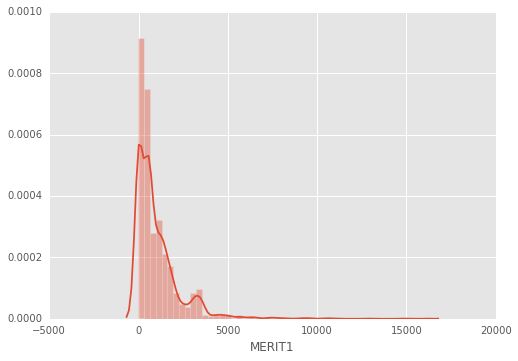

In [216]:
sns.distplot(curr.loc[idx,'MERIT1'])

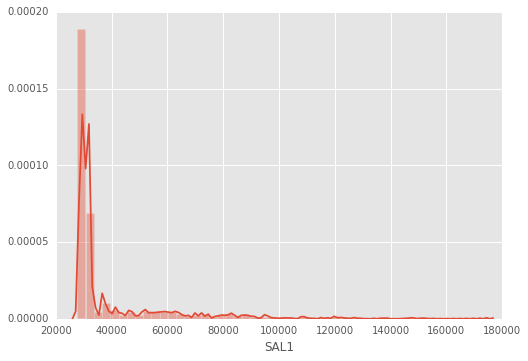

In [217]:
sns.distplot(curr.loc[idx,'SAL1'])

In [218]:
curr.loc[idx,'SAL1'].describe()

count      2587.000000
mean      38048.109153
std       19611.044825
min       27800.000000
25%       28475.025000
50%       30278.030000
75%       32195.165000
max      174972.420000
Name: SAL1, dtype: float64

In [266]:
curr.loc[idx,'JOB_FUNCTION_PSA'].value_counts()

1    2048
0     539
Name: JOB_FUNCTION_PSA, dtype: int64

## what why such a high salary here?

In [229]:
curr.loc[idx[curr.loc[idx,'SAL1']>40000]][['GRADE','SAL1','Age_years','Tenure_years','JOBCODE']].head()

,GRADE,SAL1,Age_years,Tenure_years,JOBCODE
93611,MG2,91267.48,46.672142,22.986995,2689
93612,MG2,78602.87,51.274470,17.103354,2689
93613,MG2,83823.09,40.826831,15.225188,2689
93614,RA3,74558.89,57.741273,25.420945,2688
93615,RA3,95690.10,48.517454,24.616016,2688


/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


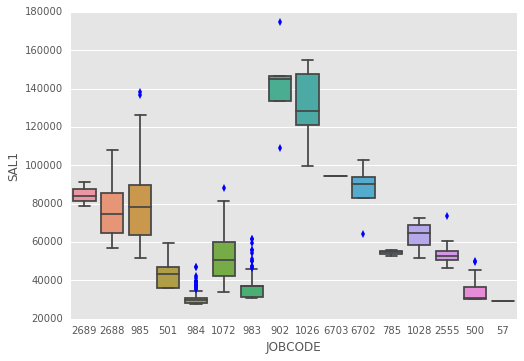

In [230]:
sns.boxplot(x='JOBCODE',y='SAL1',data =curr.loc[idx])

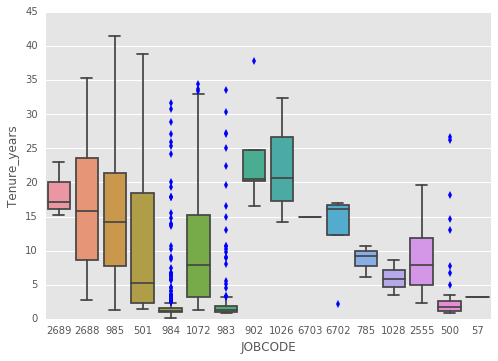

In [231]:
sns.boxplot(x='JOBCODE',y='Tenure_years',data =curr.loc[idx])

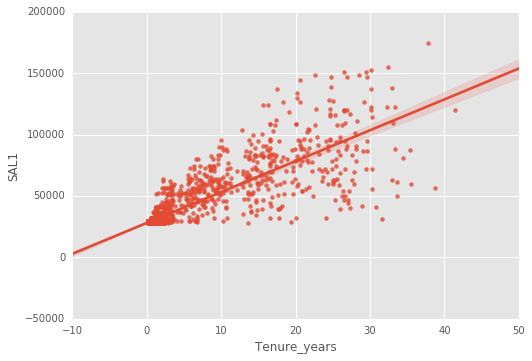

In [233]:
sns.regplot(x='Tenure_years',y='SAL1',data=curr.loc[idx])

## how many different types of JOBCODE + EXT_JOB_FUNC are there?

In [234]:
em2002.JOBCODE.nunique()

2589

In [235]:
em2002.EXT_FUNC_ID_SFI.nunique()

338

## look closer at the EXT_FUNC_ID_SFI

In [236]:
ne2b.EXT_FUNC_ID_SFI.nunique()

313

In [240]:
print(len(ne2b))*0.001

95.319


In [242]:
build_efis_vc = ne2b.EXT_FUNC_ID_SFI.value_counts()
print(sum(build_efis_vc>=100))

134


In [261]:
curr.EXT_FUNC_ID_SFI.value_counts().head()

62     6088
125    4858
909    2587
910    2462
315    2221
Name: EXT_FUNC_ID_SFI, dtype: int64

In [264]:
curr[curr.EXT_FUNC_ID_SFI==910].EXTFUNC_CNT.head()

96198    2470
96199    2470
96200    2470
96201    2470
96202    2470
Name: EXTFUNC_CNT, dtype: float64

In [255]:
build_efis_vc.head()

62     10228
125     7877
71      5173
315     3377
101     3324
Name: EXT_FUNC_ID_SFI, dtype: int64

In [252]:
build_efis_vc.head(50).cumsum()/len(ne2b)

62     0.107303
125    0.189941
71     0.244212
315    0.279640
101    0.314512
892    0.342723
910    0.370063
909    0.396899
70     0.421280
517    0.444990
328    0.463182
118    0.481226
66     0.498127
835    0.513350
986    0.527660
332    0.540060
262    0.552156
121    0.564148
116    0.575982
224    0.587102
988    0.597782
917    0.607392
63     0.616865
90     0.625720
119    0.634270
920    0.642495
269    0.650689
816    0.658725
999    0.666132
987    0.673402
980    0.680588
123    0.686705
213    0.692810
124    0.698654
918    0.704288
916    0.709733
264    0.715020
67     0.720245
534    0.725385
707    0.730515
822    0.735604
989    0.740650
990    0.745644
68     0.750249
223    0.754456
161    0.758600
184    0.762671
897    0.766720
257    0.770749
256    0.774767
Name: EXT_FUNC_ID_SFI, dtype: float64

## Try the top 50 EXT_FUNC_ID_SFI

In [253]:
top50_efis = build_efis_vc.head(50).index.tolist()
## replace others with something else


[62,
 125,
 71,
 315,
 101,
 892,
 910,
 909,
 70,
 517,
 328,
 118,
 66,
 835,
 986,
 332,
 262,
 121,
 116,
 224,
 988,
 917,
 63,
 90,
 119,
 920,
 269,
 816,
 999,
 987,
 980,
 123,
 213,
 124,
 918,
 916,
 264,
 67,
 534,
 707,
 822,
 989,
 990,
 68,
 223,
 161,
 184,
 897,
 257,
 256]

In [ ]:
cols_to_keep = ['KEY','HIRE_DT','BIRTHDATE','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']


In [ ]:
employee_df = current[cols_to_keep].copy()

In [ ]:
employee_df.isnull().any()

In [ ]:
# get the current date
import datetime
today_timestamp = pd.to_datetime(datetime.datetime.today())
print today_timestamp
# replace with Jan 01-15
today_timestamp =pd.to_datetime(datetime.datetime.strptime('01JAN2015','%d%b%Y'))
print today_timestamp

In [ ]:
def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years

In [ ]:
## create timestamps for columns that are timestamps

employee_df[['hire_tstmp','birth_tstmp']] = employee_df[['HIRE_DT','BIRTHDATE']].applymap(lambda x: pd.to_datetime(datetime.datetime.strptime(x,'%d%b%Y')))
employee_df[['Age_years','Tenure_years']] = employee_df[['birth_tstmp','hire_tstmp']].applymap(lambda x: calculate_years(x,today_timestamp))

# now deal with the the rest of the columns (map using the above  )
columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP',]
    #'EMPL_TYPE']
# replace Y with 1 and N with 0
# replace M with 1 and F with 0 (in SEX)


In [ ]:
empl=employee_df[columns_for_modeling].copy()
empl.fillna({'HAVE_INS':'N','HAVE_DEP':'N','BOX1':0,'MERIT1':0.0,'PERF1':0.0,'SAL1':0.0},inplace=True)
empl.isnull().any()


In [ ]:
## replace specific elements based upon dictionary
replace_dict = {'HAVE_INS': {'Y':1,'N':0}, 'HAVE_DEP': {'Y':1,'N':0}, 'BOX1':{'H':3,'S':2,'L':1},'SEX':{'M':1,'F':0}}
for key,value in replace_dict.iteritems():
    empl[key].replace(value,inplace=True)


In [ ]:
# fix the dollar amounts
min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
min_min_rt_ann = 17900. # same as above
min_max_rt_ann = 33155.70

max_max_rt_ann = 133068.91
min_merit1 = 0.0
min_perf1 = 0.0
fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}
fix_max_outlier_col_dict = {'MAX_RT_ANNUAL': max_max_rt_ann}

# replace these values
for key,value in fix_min_outlier_col_dict.iteritems():        
    idx_to_replace = empl[empl[key]<value].index
    empl.loc[idx_to_replace,key]=value

    # dummy empl_type categories
    #empl_type_dummy_cat = ['EMPL_TYPE_E', 'EMPL_TYPE_H', 'EMPL_TYPE_N', 'EMPL_TYPE_S', 'EMPL_TYPE_X', 'EMPL_TYPE_nan']


In [ ]:
X = empl.as_matrix()

In [ ]:
np.shape(X)

In [ ]:
# define the application of a series of time-based model
def apply_time_models(X,MODEL_BASE_PATH,pcase,pred_years):
    proba_df = []


    import joblib as jl
    import pandas as pd

    for idx,pyr in enumerate(pred_years):
        pkl_name ='rf'+pyr+'.pkl'#5.pkl'
        if pcase == 'ret/':
            pkl_name = 'R'+pkl_name

        path_name =MODEL_BASE_PATH+pcase+pyr+'/'
        print path_name, pkl_name

        # load a model, evaluate it and return the 'average' probability for each person
        #abs_mdl_name = os.path.abspath(path_name+pkl_name)
        mdl_name = path_name+pkl_name
        stored_mdl = jl.load(mdl_name)
        stored_prediction = evaluate_models(stored_mdl,X)#stored_pred,stored_pred_proba = evaluate_models(stored_mdl,X)

        df = pd.DataFrame(stored_prediction.T)
        df.columns=[pcase[:-1]+pyr+'yr']

        proba_df.append(df)

    pred_df = pd.concat([a for a in proba_df], axis=1)
    return pred_df

# define a function to apply a set of models to a given prediction
## now apply each model to my eval set
def evaluate_models(model_list,X,mode='mean',offset=0):
    """ Function to apply a set of models to a given input and generate the predicted value(s)
    :param model_list --> input list of models
    :param X --> input array to apply models to
    :param mode --> what sort of output to return; default is mean
    intermediates
        eval_pred_class --> array of classification prediction for each model
        eval_pred_proba --> array of predicted probabilities for each model
    """
    import numpy as np
    eval_pred_class = np.zeros((len(X),len(model_list)))
    eval_pred_proba = np.zeros((len(X),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(X)
        eval_pred_class[:,i]=mdl.predict(X)
        eval_pred_proba[:,:,i]=eval_proba
    if mode == 'mean':
        # average the probabilities (for class=1) and return the mean predicted probability
        prediction = np.mean(eval_pred_proba[:,1,:],axis=1)
        #eval_pred_proba[:,1,:].mean(axis=2)

    elif mode == 'class': # return the desired class prediction
        prediction = map(np.int,eval_pred_class.mean(axis=1))
    return prediction


In [ ]:
# load the model
MODEL_BASE_PATH = '/home/kesj/projects/hrsepara/model/'
#MODEL_BASE_PATH = 'C:\\Users\\kesj\\code\\hrsep1\\model_1\\'
pred_cases = ['sep/','ret/']
pred_years = map(np.str,np.arange(1,6))

sep_proba_df = apply_time_models(X,MODEL_BASE_PATH,pred_cases[0],pred_years)
ret_proba_df = apply_time_models(X,MODEL_BASE_PATH,pred_cases[1],pred_years)
sep_proba_df.index=employee_df.KEY
ret_proba_df.index=employee_df.KEY

## now check on the rates of retirements for each of the coming years
* calculate the total number of retirements and rate of retirement.
    * option 1: sum the probabilities
    * option 2: apply a threshold and sum in binary way.
    

In [ ]:
np.shape(ret_proba_df), np.shape(sep_proba_df)

In [ ]:
sep_proba_df.head()

In [ ]:
simple_rates = pd.DataFrame(sep_proba_df.sum()/float(len(sep_proba_df)))
simple_rates.index = ['yr1','yr2','yr3','yr4','yr5']
simple_rates.columns = ['Separation']
simple_rates['Annual Separation'] = simple_rates.diff()
simple_rates.loc['yr1','Annual Separation']= simple_rates.loc['yr1','Separation']

In [ ]:
tmp_rates = pd.DataFrame(ret_proba_df.sum()/float(len(ret_proba_df)))
tmp_rates.index = ['yr1','yr2','yr3','yr4','yr5']
tmp_rates.columns = ['Retirement']
tmp_rates['Annual Retirement'] = tmp_rates.diff()
tmp_rates.loc['yr1','Annual Retirement']= tmp_rates.loc['yr1','Retirement']
simple_rates = pd.concat([simple_rates,tmp_rates],axis=1)
simple_rates

## what were historical rates?

In [ ]:
### load in the federal unemployment data
unempl_raw = pd.read_csv('../eda/us_unemployment_monthly_seas.csv')
unempl_raw.head()
### convert to useable format
unempl = pd.melt(unempl_raw, id_vars='Year')
unempl.sort('Year', inplace=True)
unempl['date'] = unempl[['Year','variable']].apply(lambda x: pd.to_datetime(x[1]+str(x[0]),format='%b%Y'),axis=1)
unempl.sort('date',inplace=True)
unempl.head()

In [ ]:
plt.plot(unempl.date,unempl.value)

In [ ]:
unempl.groupby('Year')['value'].mean()

## calculate the historical rates of retirement and separation

In [ ]:
em2002[['hire_tstmp','term_tstmp']] = em2002[['HIRE_DT','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.datetime.strptime(x,'%d%b%Y')))


In [ ]:
monthly_range_terminations = pd.date_range(em2002.term_tstmp.min(),em2002.term_tstmp.max(),freq='M')
print len(monthly_range_terminations)
monthly_range_terminations

In [ ]:
monthly_range_terminations[0]-1

In [ ]:
len(em2002[(em2002.term_tstmp <= monthly_range_terminations[1]) & (em2002.retired == 0) & (em2002.term_tstmp > monthly_range_terminations[0])])

In [ ]:
nactive = []
nsep2 = []
nhired = []
nretired = []
prev_date = monthly_range_terminations[0]-1
#nsep.append(0.0)
for idx, my_date in enumerate(monthly_range_terminations):
    nactive.append( len(em2002[(em2002.hire_tstmp < my_date) &(em2002.term_tstmp > my_date)]))
    if idx == 0:
        nsep2.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date)]))
        nretired.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) & (em2002.retired==1)]))
        nhired.append( len(em2002[(em2002.hire_tstmp <= my_date) &(em2002.hire_tstmp > prev_date)]))
    else:
        nsep2.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) &( em2002.term_tstmp > monthly_range_terminations[idx-1])]))
        nretired.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) & (em2002.retired==1) &( em2002.term_tstmp > monthly_range_terminations[idx-1])]) )
        nhired.append( len(em2002[(em2002.hire_tstmp <= my_date) &(em2002.hire_tstmp > monthly_range_terminations[idx-1])]))
        

In [ ]:
workforce= pd.DataFrame(data =nactive,index=monthly_range_terminations,columns=['Active'])
delta = workforce.diff()
workforce['netChange'] = delta
workforce['AllSeparations'] = nsep2
workforce['Hires'] = nhired
workforce['Retirements'] = nretired
workforce.head()

In [ ]:
plt.plot(monthly_range_terminations,nactive)
plt.xlabel('Date')
plt.ylabel('Worforce Counts')

In [ ]:
annualwf = pd.DataFrame()
annualwf = workforce[['AllSeparations','Hires','Retirements']].resample('A',how='sum')#.plot()
annualwf['Active'] =workforce['Active'].resample('A',how='last')
annualwf.head()

In [ ]:
annualwf['Separations']=annualwf['AllSeparations']-annualwf['Retirements']
annualwf['SepRate']=annualwf['Separations']/annualwf['Active']
annualwf['RetRate']=annualwf['Separations']/annualwf['Active']


In [ ]:
(annualwf.AllSeparations/annualwf.Active).plot()